# Overview

We are proposing to compete in the Kaggle competition setup by Rossman Stores to predict store sales for the next 6 weeks of business from previous business data.. All the information on the dataset is  \textcolor{blue}{\href{https://www.kaggle.com/c/rossmann-store-sales/data}{here}}. There's information about competitors, daily sales grosses, etc. 

## Code Location
Our exploratory code is found \textcolor{blue}{\href{https://github.com/meissnereric/rossman_predictor}{on Eric's github}.}

## Descriptive Statistics and Discussion

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%pwd

u'/home/eric/dev/projects/data_science/rossman_predictor'

In [2]:
#Partial code taken from (https://www.kaggle.com/mmourafiq/rossmann-store-sales/data-viz/notebook): 

train = pd.read_csv('data/train.csv')
#print(train[:5])
store = pd.read_csv('data/store.csv')
#print(store[:5])
all_data = pd.merge(train, store, on='Store', how='left')
test = pd.read_csv('data/test.csv')
all_data['StateHoliday'][all_data['StateHoliday'] == 0 ] = '0'

/usr/local/lib/python2.7/dist-packages/pandas/io/parsers.py:1164: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Basic stats of the data. Notice particularly the standard deviation is high for both sales and customers, ipmlyign the data is highly variable and reassuring us that a predictor is necessary.

Unsurprisingly, a state holiday strongly affects sales. 

In [3]:
print test

          Id  Store  DayOfWeek        Date  Open  Promo StateHoliday  \
0          1      1          4  2015-09-17     1      1            0   
1          2      3          4  2015-09-17     1      1            0   
2          3      7          4  2015-09-17     1      1            0   
3          4      8          4  2015-09-17     1      1            0   
4          5      9          4  2015-09-17     1      1            0   
5          6     10          4  2015-09-17     1      1            0   
6          7     11          4  2015-09-17     1      1            0   
7          8     12          4  2015-09-17     1      1            0   
8          9     13          4  2015-09-17     1      1            0   
9         10     14          4  2015-09-17     1      1            0   
10        11     15          4  2015-09-17     1      1            0   
11        12     16          4  2015-09-17     1      1            0   
12        13     19          4  2015-09-17     1      1         

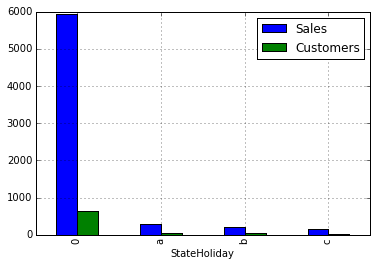

In [4]:
avg_stateholiday = all_data[['Sales', 'Customers', 'StateHoliday']].groupby('StateHoliday').mean()
avg_stateholiday.plot(kind='bar')

Notably, having a promotion running for a particular day increases sales by quite a large amount, while not increasing customers by nearly the same rate. This implies people are spending more during those days, instead of having simply higher rates of customers.

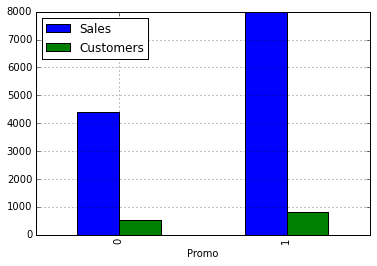

In [5]:
avg_promotion = all_data[['Sales', 'Customers', 'Promo']].groupby('Promo').mean()
avg_promotion.plot(kind='bar')

Competition distances are clustered around having close competitors, and in general it doesn't appear to affect sales strongly. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f906cebcd50>]], dtype=object)

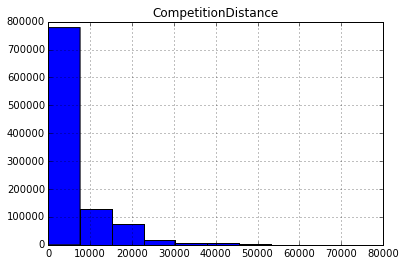

In [6]:
all_data.hist('CompetitionDistance')

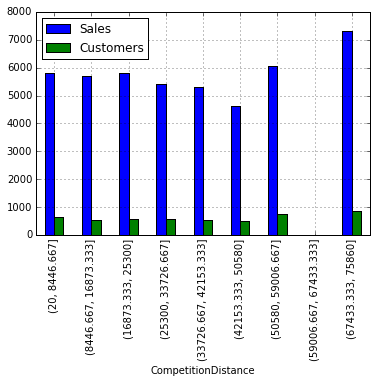

In [7]:
# Bin the competition distance with 10 bins
bins = np.linspace(all_data['CompetitionDistance'].min(), all_data.CompetitionDistance.max(), 10)

competition_bins = all_data[['Sales', 'Customers']].groupby(pd.cut(all_data['CompetitionDistance'], bins))
competition_avg = competition_bins.mean()
competition_avg.plot(kind='bar')

Sundays have almost no sales.

Sales peak in July and December, the peak of summer and Christmas season (The data is from Rossman stores, which are based in Germany so Christmas would be a major holiday.)

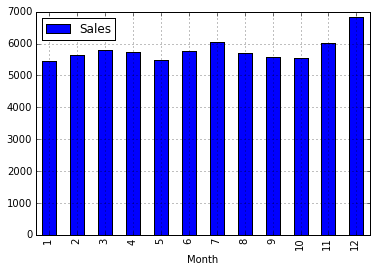

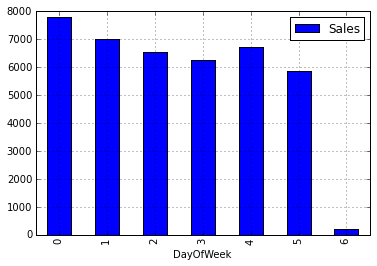

In [8]:
#Done By Neal
train['Date'] = pd.to_datetime(train['Date'])
train[:5]['Date'].dt.dayofweek
train['DayOfWeek'] = train['Date'].dt.dayofweek
train['Month'] = train['Date'].dt.month
train['Year'] = train['Date'].dt.year
avg_month = train[['Sales', 'Month']].groupby('Month').mean()
avg_month.plot(kind='bar')
avg_day = train[['Sales', 'DayOfWeek']].groupby('DayOfWeek').mean()
avg_day.plot(kind='bar')
#sales by day of week
sale_dayofweek = pd.pivot_table(train, values='Sales', index=['Year','Store'], columns=['DayOfWeek'])

#sales by month
sale_month = pd.pivot_table(train, values='Sales', index=['Year','Store'], columns=['Month'])
#sale_dayofweek.plot(kind='box')
#sale_month.plot(kind='box')

## Place in Data Science Model
Our model will use a typical data science procedure for batch data analysis including a cleaning phase that feeds into a predictive regression model for sales prediction.

## Next Steps
The next steps mainly include deciding on a particular predictive mode, through both empirical testing and looking at what popular methods for time series regression are used in the field.

Because our goal is to build a sales predictor, visualization of the results isn't a particular goal, though we plan to visualize and discuss major patterns in the data that our analysis finds, such as having a store with a promotion increasing sales by X or discussing the relation of stores to their competitors. We will also include a visualization of our predictor if relevant. 


# Final Product - The Predictor
So for the model I just used a simple linear regression (ordinary least squares) because A) it's not a classification or clustering problem so the fancy things aren't really helpful and B) because it's super easy and the problem honestly looked like it would be captured well by a linear model. 

So here I drop columns that weren't helpful / difficult to clean and merge it with the store data. I also clean everything to be numbers and turn the categorical variables into dummy variables.

The next cell takes ~1-2 minutes to run since it's doing element wise operations.

In [9]:
string_cols = ['Date']
drop_cols = ['Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']
tw_pre = train.drop(string_cols, axis=1).applymap(lambda x: int(x)
                            if str.isdigit(str(x))
                            else np.nan)
tw = pd.merge(tw_pre, store, on='Store', how='left')
tw = tw.drop(drop_cols, axis=1)
#tw['Date'] = train['Date']

In [10]:

st_dummies = pd.get_dummies(tw.StoreType, prefix='store').iloc[:, 1:]
assort_dummies = pd.get_dummies(tw.Assortment, prefix='assort').iloc[:, 1:]
tw_F = pd.concat([tw, st_dummies, assort_dummies ], axis=1)

tw.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Month,Year,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear
0,1,4,5263,555,1,1,0,1,7,2015,c,a,1270,9,2008
1,2,4,6064,625,1,1,0,1,7,2015,a,a,570,11,2007
2,3,4,8314,821,1,1,0,1,7,2015,a,a,14130,12,2006
3,4,4,13995,1498,1,1,0,1,7,2015,c,c,620,9,2009
4,5,4,4822,559,1,1,0,1,7,2015,a,a,29910,4,2015


We only want to use those features in the training data that also exist in the test data, since we're just using a linear model.

In [11]:
feature_cols = ['DayOfWeek', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
                'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear',
                'store_b', 'store_c', 'store_d', 'assort_b', 'assort_c']

all_test = pd.merge(test.drop(string_cols, axis=1).applymap(lambda x: int(x)
                            if str.isdigit(str(x))
                            else 0), store, on='Store', how='left')
all_test = all_test.drop(drop_cols, axis=1)
all_test = pd.concat([all_test, st_dummies, assort_dummies ], axis=1)


Here I interpolate missing data in the set using Pandas built-in stuff (which does it using a linear model as well) because it looked like it worked well, and it's the easiest way to clean it up.

Then we build a simple ordinary least squares regression model and fit the data to it! Runs pretty fast.

The coefficients are simple coefficients for our model that looks more or less like
$$Sales = x_1 \cdot DayOfWeek + x_2 \cdot Open + \cdots + x_n \cdot assort_c$$

In [12]:
from sklearn.linear_model import LinearRegression

X = tw_F[feature_cols].interpolate()
tstX = all_test[feature_cols].interpolate()
y = tw_F.Sales.interpolate()

# instantiate, fit
lm = LinearRegression()
lm.fit(X, y)

# print coefficients
print zip(feature_cols, lm.coef_)


[('DayOfWeek', -115.40549422234382), ('Open', 5773.5998894642316), ('Promo', 2077.8644682123872), ('StateHoliday', 1.4702938265765719e-12), ('SchoolHoliday', 64.892674989404995), ('CompetitionDistance', -0.013191911933166035), ('CompetitionOpenSinceMonth', -18.011177289364802), ('CompetitionOpenSinceYear', 2.1290352834617328), ('store_b', 5223.9145880647429), ('store_c', -94.351286575149203), ('store_d', -245.26100339374534), ('assort_b', -3128.6809364533688), ('assort_c', 700.21287024484195)]


So here we're predicting! 
$r$ is the error of the predictions for a given datum.
$y_{pred}$ is the predicted value.
$y$ is the ground truth.
$mean_{sq}$ is the mean-squared-error of the predictions.

We can run the results on the test data, but we have no way to test how good our predictions and thus no way to check error.

For visualizations if you run the tstX line then plot that data "appended" to the training data we can probably visually see how well our predictions were. I know they're not great, but at least it does something :).

Cheers! - Eric 


In [22]:
y_pred = lm.predict(X)
#y_pred = lm.predict(tstX)
y_mean = np.mean(y)
r =  y - y_pred
mean_sq = sum(map(lambda x: (y_mean - x) ** 2, y_pred))
print zip(y, y_pred, r)[:10]
print mean_sq

[(5263, 7611.554166074935, -2348.554166074935), (6064, 7676.9884011411104, -1612.9884011411104), (8314, 7477.9658627545523, 836.03413724544771), (13995, 8322.4708143597982, 5672.5291856402018), (4822, 7433.0482283152651, -2611.0482283152651), (5651, 7675.1813326551401, -2024.1813326551401), (15344, 8206.9672275181965, 7137.0327724818035), (8492, 7618.2190374792026, 873.7809625207974), (8565, 8397.071364847392, 167.92863515260797), (7185, 7683.1017743798639, -498.10177437986385)]
8.37286239992e+12


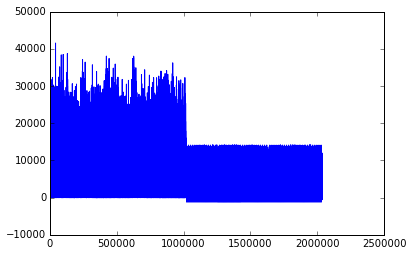

In [25]:
whole_set = pd.DataFrame([pd.Series(np.append(train['Sales'], y_pred)), train['Date']
plt.plot(whole_set)

Proceed at your own risk to this bottom portion. I started building a neural network to work on the data but it's just too big for my computer honestly. We can talk about that in the slides though! Feel free to play around; it's only working with the first ~10,000 values right now so that it's trainable in a reasonable amount of time. Doesn't work well though of course. 


In [14]:
from pybrain.structure.modules import SoftmaxLayer, LinearLayer
from pybrain.utilities import percentError
from pybrain.tools.shortcuts import buildNetwork
from pybrain.datasets import SupervisedDataSet
from pybrain.supervised.trainers import BackpropTrainer
#ds = SupervisedDataSet( len(X.columns), 1 )
#for i, item in X.iterrows():
#    if i > 10000:
#        break
#    ds.appendLinked( item, y[i])

In [15]:
#tstdata, trndata = ds.splitWithProportion( 0 )
#print len(ds.getField('target'))

In [16]:
#print "Number of training patterns: ", len(trndata)
#print "Number of testing patterns: ", len(tstdata)
#print "Input and output dimensions: ", trndata.indim, trndata.outdim
#print "First sample (input, target, class):"
#print trndata['input'][0], trndata['target'][0]
#print trndata['input'][-1], trndata['target'][-1]

In [17]:
#fnn = buildNetwork( trndata.indim, 1, trndata.outdim, outclass=LinearLayer)
#trainer = BackpropTrainer( fnn, dataset=trndata, verbose=True)#,  learningrate=0.001)# momentum=0.05, weightdecay=0.005) 

In [18]:
#trainer.train()

In [19]:
#for i in range(15):
#    trainer.trainEpochs( 10 )
#    #trainer.trainUntilConvergence(maxEpochs=30)
#    print 
#    test1 = fnn.activate(trndata['input'][0])
#    test2 = fnn.activate(trndata['input'][-1])
#    print test1, test2